# 演習課題8回目

12月15日(金)

1. がん診断データセット (Breast Cancer Wisconsin Data Set, `wisc_bc_data.csv`) から決定木 (Decision Tree) を構築したい．
2. 最適な木のサイズが不明なので，k分割交差検証により最適なサイズおよびその性能を把握したい．
3. また，得られた結果をもとに検証曲線を描く．

* 木のサイズを表すハイパーパラメータは，最大深さ: `max_depth`, 葉の最大数: `max_leaf_nodes`のどちらかを選択
* Gini不純度か情報エントロピを選択
* kの値は，5か10

## セットアップ

In [1]:
# Pythonが実行時のバージョンを満たしているか確認する
import sys
assert sys.version_info >= (3, 9, 7)
# 必要なモジュールのインポート
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
# サードパーティ製ライブラリが実行時のバージョンを満たしているか確認する
assert np.__version__ >= '1.20.3'
assert pd.__version__ >= '1.3'
assert sklearn.__version__ >= '0.24'
# データの保存場所の定義
DATA_ROOT_PATH = Path('data', '10')
# matplotlib の日本語対応
# plt.rcParams['font.family'] = "MS Gothic"


## データの取得

In [2]:
from sklearn.model_selection import train_test_split
wisc_bc = pd.read_csv(DATA_ROOT_PATH / "wisc_bc_data.csv", index_col=0)
train_set, test_set = train_test_split(wisc_bc, test_size=0.2, random_state=42)

data_train, data_test = train_set.iloc[:, :-1], test_set.iloc[:, :-1]
label_train, label_test = train_set.iloc[:, -1], test_set.iloc[:, -1]


In [3]:
data_train.describe()


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,points_mean,symmetry_mean,dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,points_worst,symmetry_worst,dimension_worst
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,14.098492,19.335692,91.833648,650.748791,0.096803,0.105994,0.089737,0.049001,0.181338,0.063005,...,16.235635,25.710088,107.154725,875.384835,0.133079,0.259669,0.277133,0.115608,0.290904,0.084532
std,3.458153,4.350443,23.898849,340.339357,0.014291,0.053993,0.081321,0.038737,0.027345,0.007158,...,4.760919,6.135252,33.286757,556.708422,0.022980,0.163162,0.217008,0.066293,0.063224,0.018831
min,6.981000,10.380000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.490000,50.410000,185.200000,0.081250,0.034320,0.000000,0.000000,0.156500,0.055040
25%,11.745000,16.210000,75.525000,424.800000,0.086390,0.066525,0.029805,0.020690,0.161900,0.058415,...,13.065000,21.360000,84.470000,517.150000,0.117400,0.147900,0.116600,0.065225,0.250100,0.071865
50%,13.450000,18.830000,87.020000,557.200000,0.096860,0.095090,0.061540,0.033700,0.179400,0.061610,...,15.010000,25.400000,98.370000,694.400000,0.132300,0.214100,0.228200,0.099930,0.281900,0.080090
75%,15.740000,21.860000,103.650000,770.050000,0.105400,0.130800,0.132000,0.073820,0.195400,0.066395,...,18.280000,29.795000,124.200000,1033.500000,0.146000,0.341600,0.385700,0.162500,0.318150,0.092145
max,27.420000,39.280000,186.900000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.290600,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


## データの加工


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

X: np.ndarray = pipeline.fit_transform(data_train)
y: np.ndarray = label_train.to_numpy()
X[:5]


array([[-0.07193605, -0.95628562, -0.1191178 , -0.18633907, -0.11511799,
        -0.53980685, -0.55332473, -0.30732077,  1.08594252, -0.62582034,
        -0.58894677, -0.56026155, -0.53692454, -0.48319776, -0.93587717,
        -0.58023112, -0.56655326, -0.24201169, -0.63950737, -0.82310488,
        -0.2640283 , -0.64780674, -0.26420101, -0.3693332 , -0.6351271 ,
        -0.53544889, -0.60678705, -0.23675446,  0.07277859, -0.81932961],
       [ 0.57073182,  0.0723268 ,  0.51382614,  0.4910833 , -0.35889618,
        -0.40334249,  0.09790233,  0.44912696, -0.05630789, -1.27192659,
         1.32421921, -0.37287693,  1.16622553,  0.94233839,  1.19316903,
        -0.21951102,  0.08001416,  0.99479824, -0.61297023, -0.69505094,
         0.74318749, -0.18766202,  0.65098262,  0.62509884,  0.73715003,
        -0.33849571,  0.02660373,  0.54956549, -0.41016735, -1.09843262],
       [-0.19062696,  0.51644805, -0.23682611, -0.25811113, -1.0636113 ,
        -0.84703708, -0.72185589, -0.74149644, -0

## k 分割交差検証

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate


def decision_tree_cross_val(X, y, max_depth_values):
    """決定木モデルの訓練とk-分割交差検証

    Args:
        X: データ
        y: ラベル
        max_depth_values: 検証する`max_depth`の値の配列

    Returns:
        tuple: 各max_depthに対する訓練スコアとテストスコアが組になったタプル
    """

    train_scores = []
    test_scores = []
    for max_depth in max_depth_values:
        decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
        cv_results = cross_validate(decision_tree, X, y, cv=5, return_train_score=True)
        train_scores.append(np.mean(cv_results['train_score']))
        test_scores.append(np.mean(cv_results['test_score']))

    return (train_scores, test_scores)


In [6]:
max_depth_values = range(2, 10)
train_scores, test_scores = decision_tree_cross_val(X, y, max_depth_values)
test_scores


[0.8967032967032967,
 0.9274725274725274,
 0.9142857142857143,
 0.9164835164835164,
 0.923076923076923,
 0.9164835164835164,
 0.9164835164835164,
 0.9164835164835164]

In [7]:
def plot_cross_val(ax, train_scores, test_scores, max_depth_values):
    ax.plot(max_depth_values, train_scores, label='Training accuaracy')
    ax.plot(max_depth_values, test_scores, label='Test (validation) accuaracy')
    ax.set_xlabel("Max depth")
    ax.set_ylabel('Score')
    ax.grid()
    ax.legend()

    return ax


## 検証曲線の描画

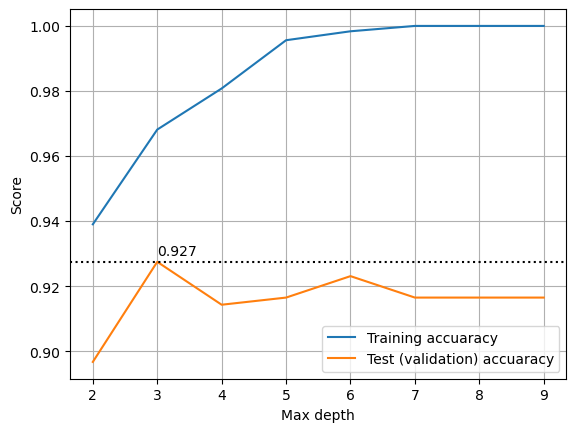

In [9]:
max_test_score = max(test_scores)

fig, ax = plt.subplots()
ax = plot_cross_val(ax, train_scores, test_scores, max_depth_values)
ax.axhline(max_test_score, c='k', linestyle=':')
ax.text(3, max_test_score+0.002, str(round(max_test_score, 3)))
plt.show()
